In [1]:
! pip install pybaseball

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pybaseball
import numpy as np # library for numerical computations (vectors, matrices, tensors)
import numpy.testing as np_testing # for tests
import matplotlib.pyplot as plt # library providing tools for plotting data
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans # library for K-Means clustering
from sklearn import metrics # library providing score functions, performance metrics and pairwise metrics and distance computations
from sklearn.metrics import mean_squared_error, confusion_matrix as calculate_confusion_matrix
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D # library for 3D axes object
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [3]:
#types = pybaseball.statcast(start_dt="2022-05-07", end_dt="2022-11-05").columns

In [4]:
#print(types)

# what the data looks like

In [5]:
#pybaseball.cache.enable()
data = pybaseball.statcast(start_dt="2022-05-07", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:18<00:00,  9.89it/s]


In [6]:
data_small = data.loc[data['game_type'] == 'R', ['pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z']].reset_index(False)


In [7]:
data_small = data_small.drop(columns=["index"])

In [8]:
data_small = data_small.dropna()

In [9]:
def count_data_points_per_label(dataframe):
    # Use the 'groupby' function to group by the 'Label' column and count the occurrences
    label_counts = dataframe['pitch_type'].value_counts().reset_index()
    label_counts.columns = ['pitch_type', 'Count']
    
    # Sort the result by counts in descending order
    label_counts = label_counts.sort_values(by='Count', ascending=False)
    
    # Convert the result to a list of dictionaries
    label_counts_list = label_counts.to_dict('records')
    
    return label_counts_list

label_counts_list = count_data_points_per_label(data_small)
print(label_counts_list)

[{'pitch_type': 'FF', 'Count': 196170}, {'pitch_type': 'SL', 'Count': 104795}, {'pitch_type': 'SI', 'Count': 92786}, {'pitch_type': 'CH', 'Count': 66466}, {'pitch_type': 'CU', 'Count': 46505}, {'pitch_type': 'FC', 'Count': 43246}, {'pitch_type': 'ST', 'Count': 18002}, {'pitch_type': 'KC', 'Count': 12992}, {'pitch_type': 'FS', 'Count': 9161}, {'pitch_type': 'SV', 'Count': 2065}, {'pitch_type': 'FA', 'Count': 1118}, {'pitch_type': 'EP', 'Count': 506}, {'pitch_type': 'CS', 'Count': 62}, {'pitch_type': 'PO', 'Count': 35}, {'pitch_type': 'KN', 'Count': 19}]


In [10]:
def remove_rows_by_label(dataframe, label_to_remove):
    # Use boolean indexing to filter rows based on the label to remove
    filtered_df = dataframe[dataframe['pitch_type'] != label_to_remove]
    return filtered_df

remove_types = ['KN', 'PO', 'CS', 'EP', 'FA', 'SV']
filtered_data_small = data_small
for label in remove_types:
    filtered_data_small = remove_rows_by_label(filtered_data_small, label)
print(count_data_points_per_label(filtered_data_small))

[{'pitch_type': 'FF', 'Count': 196170}, {'pitch_type': 'SL', 'Count': 104795}, {'pitch_type': 'SI', 'Count': 92786}, {'pitch_type': 'CH', 'Count': 66466}, {'pitch_type': 'CU', 'Count': 46505}, {'pitch_type': 'FC', 'Count': 43246}, {'pitch_type': 'ST', 'Count': 18002}, {'pitch_type': 'KC', 'Count': 12992}, {'pitch_type': 'FS', 'Count': 9161}]


In [11]:
validation_size = 0.20  # 20% for validation
testing_size = 0.80  # 80% for testing

In [12]:
validation_data, training_data = train_test_split(filtered_data_small, test_size=testing_size, random_state=42)

In [13]:
validation_data, testing_data =  train_test_split(validation_data, test_size=0.5, random_state=42)

In [14]:
y = training_data["pitch_type"]
X = training_data.drop(columns=["pitch_type"])
y_test = testing_data["pitch_type"]
X_test = testing_data.drop(columns=["pitch_type"])
y_val = validation_data["pitch_type"]
X_val = validation_data.drop(columns=["pitch_type"])

In [15]:
X1 = X.to_numpy()
y1 = y.to_numpy()
X_test1 = X_test.to_numpy()
y_test1 = y_test.to_numpy()
X_val1 = X_val.to_numpy()
y_val1 = y_val.to_numpy()

In [16]:
alltypes = []
n = 0
for i in y1:
    if (i not in alltypes):
        #print(i)
        if(i ==None):
            print(n)
        alltypes.append(i)
    n = n +1 
print(alltypes)
print(len(alltypes))


['FF', 'SL', 'CH', 'KC', 'CU', 'FC', 'SI', 'ST', 'FS']
9


In [18]:
#k_values = [1, 3, 5, 7, 9, 11]

# Iterate over K values and evaluate the model
#for k in k_values:
#    knn = KNeighborsClassifier(n_neighbors=k)
#    scores = cross_val_score(knn, X1, y1, cv=5, scoring='accuracy')
#    mean_score = scores.mean()
#    print(f"K={k}: Mean Accuracy = {mean_score}")

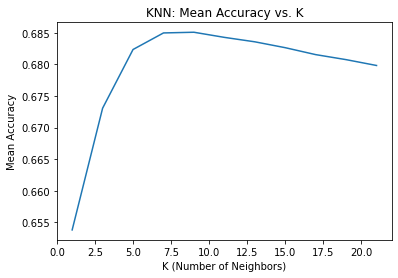

In [19]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X1, y1, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())

plt.plot(k_values, mean_scores)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Accuracy')
plt.title('KNN: Mean Accuracy vs. K')
plt.show()

Elbow test shows would indicate k = 5 or k = 7 would be good choices

In [28]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X1,y1)

KNeighborsClassifier(n_neighbors=7)

In [20]:
#kmeans = KMeans(random_state = 0, n_clusters = 15)
#kmeans.fit(X1,y1)

In [29]:
y_test_pred = neigh.predict(X_test1)

In [30]:
acc = accuracy_score(y_test_pred,y_test1)
confmat = confusion_matrix(y_test1, y_test_pred)

Accuracy: 0.6864197112451704


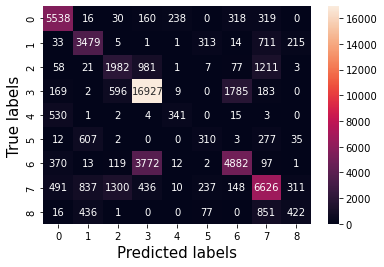

In [27]:
print("Accuracy:", acc)

# plot the confusion matrix
ax = plt.subplot()
sns.heatmap(confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()